# Groups of inputs based on their performances : the case study of x264 and the bitrate

#### First, we import some libraries

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sc
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
from scipy.stats import mannwhitneyu

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import os

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

Using TensorFlow backend.


#### Then we import x264 data

In [2]:
res_dir = "../../../data/x264/"

v_names = sorted(os.listdir(res_dir)) 
# so we keep the same ids between two launches
v_names.remove("others")

listVideo = []

for v in v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    listVideo.append(data)

input_sizes = pd.read_csv("../../../data/x264/others/ugc_meta/sizes.csv", delimiter=',').set_index('name')

for i in range(len(listVideo)):
    input_video_size = input_sizes.loc[v_names[i][:-4]]['size']
    listVideo[i]['crate'] = listVideo[i]['size']/input_video_size
    
predDimension = "kbs"

for i in range(len(listVideo)):
    sizes = listVideo[i][predDimension]
    ind = sorted(range(len(sizes)), key=lambda k: sizes[k])
    listVideo[i]['ranking'] = ind

## Groups of inputs based on performances

In [3]:
nbVideos = len(listVideo)
corrSpearman = [[0 for x in range(nbVideos)] for y in range(nbVideos)]

for i in range(nbVideos):
    for j in range(nbVideos):
        if (i == j):
            corrSpearman[i][j] = 1
        else:
            corrSpearman[i][j] = sc.spearmanr(listVideo[i][predDimension],
                                            listVideo[j][predDimension]).correlation

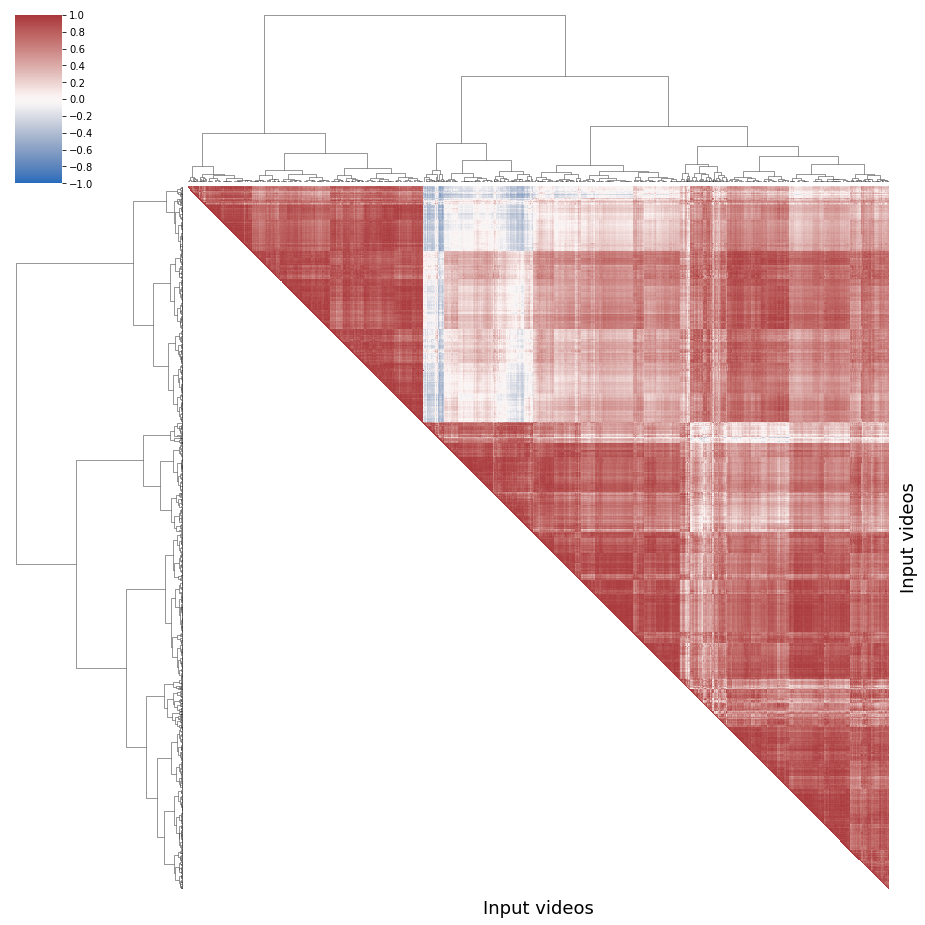

In [4]:
def plot_correlationmatrix_dendogram(corr, ticks, method= 'ward', div=False):

    df = pd.DataFrame(corr)
    
    # group the videos
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(nbVideos):
        for j in range(nbVideos):
            if i>j:
                mask[order[i]][order[j]] = True
    
    g = sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks}, vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    g.ax_heatmap.set_xlabel("Input videos", fontsize = 18)
    g.ax_heatmap.set_ylabel("Input videos", fontsize = 18)
    plt.show()
    
    return cut_tree(links, n_clusters = 4)

group_no_ordered = plot_correlationmatrix_dendogram(corrSpearman, 
                                 [k/5 for k in np.arange(-10,10,1)], method='ward')

![title](corr_kbs.png)

![title](encoding_profile_kbs.png)

Based on the previous dendogram, we report on videos' properties that can be used to characterize four performance groups: 

- Group 1. action videos (high spatial and chunk complexities, Sports and News); 
- Group 2. big resolution videos (low spatial and high temporal complexities, High Dynamic Range);
- Group 3. still image videos (low temporal and chunk complexities, Lectures and HowTo)
- Group 4. standard videos (average properties values, various contents)


The different group characteristics (i.e. inputs' properties) are depicted in the following table. 
For each group (i.e. the columns), we depict the average values of some indicators (i.e. the lines). 
To describe a bit more the distributions, average values are shown with the standard deviations.

A first observation is that the correlations within each individual group are strong (for Group 4: 0.77) or very strong (for Group 3: 0.87). 
Within a group, configurations' performance generalize over all videos. Second, we can notice that the performance effects of x264 features significantly vary across groups. 
For instance, the feature importance of `mbtree` varies from 0.09 (weak effect on Group 1) to 0.47 (strong effect on Group 2). Moreover, the coefficients of `mbtree` can be either positive or negative: the setting of `mbtree` value (either true or false) can have opposite effects depending of the group. It is exactly why we want to identify groups: as a way to tune options' values depending on input. 
Finally, there exists video properties and categories to discriminate groups. For instance, Group 1 exhibits a high spatial and chunk complexity while Group 2 exhibits a low  spatial and high temporal complexity. 

## Reduce the benchmarking cost by selecting onlye few inputs

We propose to only keep 2 videos per group, cheap inputs in terms of encoding time, but highly correlated with other videos of their groups.

These 4 groups represent 4 profile performance of inputs for the non-functional property bitrate of x264.

It'll end up with 8 videos:

#### Group 1 : "Action video"
- Gaming_360P-56fe - [Link Youtube UGC](https://console.cloud.google.com/storage/browser/_details/ugc-dataset/original_videos/Gaming/360P/Gaming_360P-56fe.mkv)
- Sports_360P-4545 - [Link Youtube UGC](https://console.cloud.google.com/storage/browser/_details/ugc-dataset/original_videos/Sports/360P/Sports_360P-4545.mkv)

#### Group 2 : "Big resolution"
- Animation_480P-087e - [Link Youtube UGC](https://console.cloud.google.com/storage/browser/_details/ugc-dataset/original_videos/Animation/480P/Animation_480P-087e.mkv)
- CoverSong_360P-5d20 - [Link Youtube UGC](https://console.cloud.google.com/storage/browser/_details/ugc-dataset/original_videos/CoverSong/360P/CoverSong_360P-5d20.mkv)

#### Group 3 : "Still image"
- Lecture_360P-114f - [Link Youtube UGC](https://console.cloud.google.com/storage/browser/_details/ugc-dataset/original_videos/Lecture/360P/Lecture_360P-114f.mkv)
- MusicVideo_360P-5699 - [Link Youtube UGC](https://console.cloud.google.com/storage/browser/_details/ugc-dataset/original_videos/MusicVideo/360P/MusicVideo_360P-5699.mkv)

#### Group 4 : "Others/standard"
- LiveMusic_360P-1d94 - [Link Youtube UGC](https://console.cloud.google.com/storage/browser/_details/ugc-dataset/original_videos/LiveMusic/360P/LiveMusic_360P-1d94.mkv)
- LyricVideo_360P-5e87 - [Link Youtube UGC](https://console.cloud.google.com/storage/browser/_details/ugc-dataset/original_videos/LyricVideo/360P/LyricVideo_360P-5e87.mkv)

## Appendix :  detailed summary per group

In [5]:
map_group = [2, 0, 3, 1]

def f(gr):
    return map_group[int(gr)]

groups = np.array([*map(f, group_no_ordered)],int)

print(sum(groups==0))
print(sum(groups==1))
print(sum(groups==2))
print(sum(groups==3))

470
219
292
416


In [10]:
meta = pd.read_csv("../../../data/x264/others/ugc_meta/all_features.csv").set_index('FILENAME')
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
del meta['NOISE_DMOS']
meta = meta.fillna(0)
cat_tab = pd.Series(meta['category'].values).unique()
meta['video_category'] = [np.where(cat_tab==meta['category'][i])[0][0] for i in range(len(meta['category']))]
del meta['category']
for col in meta.columns:#[:len(meta.columns)-1]:
    inter = np.array(meta[col],float)
    meta[col] = (inter-np.mean(inter))/np.std(inter)
perf = pd.DataFrame({'FILENAME': np.array([v_names[k][:-4] for k in range(len(v_names))]),
              'perf_group' : np.array([k for k in groups])}).set_index('FILENAME')
meta_perf = perf.join(meta)
meta_perf['str_video_cat'] = [str(meta_perf.index[i]).split('_')[0] for i in range(meta_perf.shape[0])]
total_cat = meta_perf.groupby('str_video_cat').count()['perf_group']
group_perf = np.array([gr for gr in groups])
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)
categorial = ['analyse', 'me', 'direct']

def compute_Importances(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0, len(listVid), 1)
        
    listImportances = []

    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')

        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                if col not in [predDimension,'ranking']:
                    df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                    arr_col = np.array(df[col],int)
                    arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                    df[col] = arr_col

        clf = RandomForestRegressor(n_estimators=5)
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        clf.fit(X,y)

        listImportances.append(clf.feature_importances_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').transpose()#.drop(['open_gop','qpmax'],axis=1)
    return res


def compute_poly(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    #listFeatures = ['subme','aq-mode','mbtree','cabac']
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    names = listFeatures
    final_names = []
    final_names.append('constant')
    for n in names:
        final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = LinearRegression()
        X = df.drop([predDimension],axis=1)
        #X = df[short_features]

        y = df[predDimension]
        #poly = PolynomialFeatures(degree=1, interaction_only = False, include_bias = True)    
        #X_interact = pd.DataFrame(poly.fit_transform(X))#, columns=final_names)
        #kept_names = ['subme','aq-mode','mbtree','cabac','cabac*mbtree','aq-mode*subme','cabac*subme']
        clf.fit(X,y)
        listImportances.append(clf.coef_)

    #res = pd.DataFrame({'features' : short_features})
    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').transpose()#.drop(['open_gop','qpmax'])
    #res = res.set_index('features').drop(['open_gop','qpmax']).transpose()
    return res


def boxplot_imp(res, xlim = None, criteria = 'max', name = None, xname='Feature importances', 
                x_size_text = 13, y_size_text = 20):
    if criteria == 'max':
        listImp = [(np.percentile(res[col],75), res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'range':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'name':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[2], reverse=True)

    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    
    plt.xlabel(xname, size=x_size_text)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp], size= y_size_text)
    if name:
        plt.savefig(name)
    plt.show()


def summary_group(id_group):
            
    id_list = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    v_names_group = [v_names[i][:-4] for i in range(len(v_names)) if i in id_list]
    listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
    
    print('Group '+str(id_group)+' : '+str(len(listVideoGroup))+' videos!')
    
    print('\n')
    
    video_size = [input_sizes.loc[index_vid]['size'] for index_vid in v_names_group]
    
    print("input avg size :", np.mean(video_size))
    print("input std size :", np.std(video_size))
    
    print('\n')

    # features importances
    res_imp = compute_Importances(listVideoGroup)
    
    print('\n')
    
    print('Imp mbtree:', np.mean(res_imp['mbtree']))
    print('Imp std mbtree:', np.std(res_imp['mbtree']))
    
    print('Imp aq-mode:', np.mean(res_imp['aq-mode']))
    print('Imp std aq-mode:', np.std(res_imp['aq-mode']))
    
    print('Imp subme:', np.mean(res_imp['subme']))
    print('Imp std subme:', np.std(res_imp['subme']))
    
    boxplot_imp(res_imp, criteria = 'name', xlim= (0, 1))

    # features effects
    res_poly = compute_poly(listVideoGroup)
    
    print('\n')
        
    print('Coef mbtree:', np.mean(res_poly['mbtree']))
    print('Coef mbtree std :', np.std(res_poly['mbtree']))
    print('Coef aq-mode:', np.mean(res_poly['aq-mode']))
    print('Coef aq_mode std :', np.std(res_poly['aq-mode']))
    print('Coef subme:', np.mean(res_poly['subme']))
    print('Coef subme std:', np.std(res_poly['subme']))
    
    boxplot_imp(res_poly, criteria = 'name', xlim = (-1, 1), xname = 'Coefficients')

    print('\n')

    interest_var = ['cpu', 'etime', 'fps', 'kbs', 'size']

    for iv in interest_var:
        pred = [np.mean(lv[iv]) for lv in listVideoGroup]
        print('Mean '+iv+' in the group: '+str(np.round(np.mean(pred),1)))
        print('Std dev : '+iv+' in the group: '+str(np.round(np.std(pred),1)))

    print('\n')

    # percentage of the videos present in the group par category

    meta_perf_group = meta_perf.query('perf_group=='+str(id_group))
    meta_perf_group['str_video_cat'] = [str(meta_perf_group.index[i]).split('_')[0] for i in range(meta_perf_group.shape[0])]
    val_group = meta_perf_group.groupby('str_video_cat').count()['perf_group']
    df_res_cat_group = pd.DataFrame({'val': val_group, 'total': total_cat})
    print(df_res_cat_group['val']/df_res_cat_group['total'])

    print('\n')

    # Mean of the videos of the group per properties

    for col in meta_perf_group.columns:
        if col not in ['str_video_cat', 'video_category']:
            print('Mean '+col+' : '+str(meta_perf_group[col].mean()))
            print('std '+col+' : '+str(meta_perf_group[col].std()))

    print('\n')

    corrGroup = np.array([corrSpearman[i][j] for i in range(len(corrSpearman)) if i in id_list 
                 for j in range(len(corrSpearman)) if j in id_list],float)

    print("Correlations intra-group: \n" + str(pd.Series(corrGroup).describe())+'\n')

Group 0 : 470 videos!


input avg size : 1637205973.9170213
input std size : 2438557837.558484




Imp mbtree: 0.0893404255319149
Imp std mbtree: 0.09433186700014909
Imp aq-mode: 0.2744042553191489
Imp std aq-mode: 0.19872992039068502
Imp subme: 0.48851063829787233
Imp std subme: 0.24687475266589715


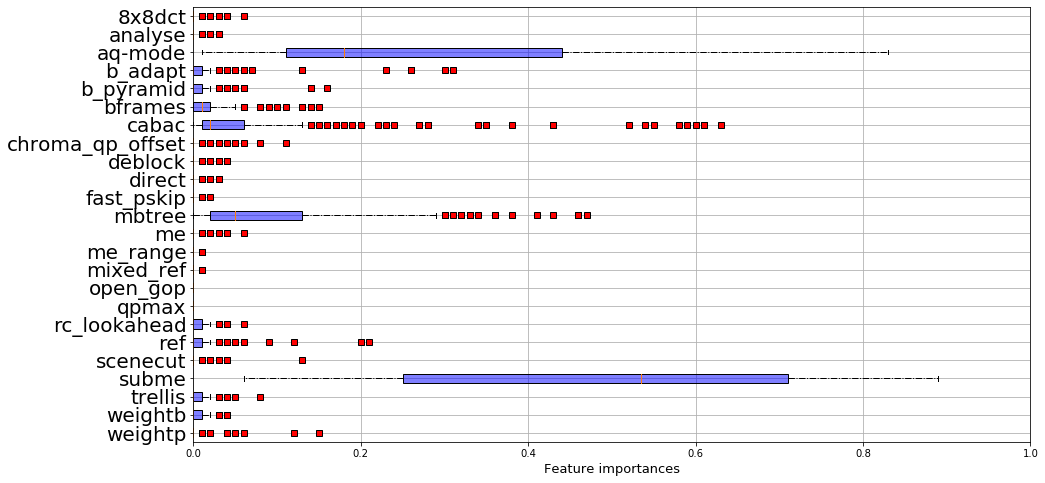



Coef mbtree: 0.33312765957446805
Coef mbtree std : 0.19396699840176548
Coef aq-mode: -0.5040851063829788
Coef aq_mode std : 0.13980804922909124
Coef subme: -0.3180851063829787
Coef subme std: 0.09194212559556819


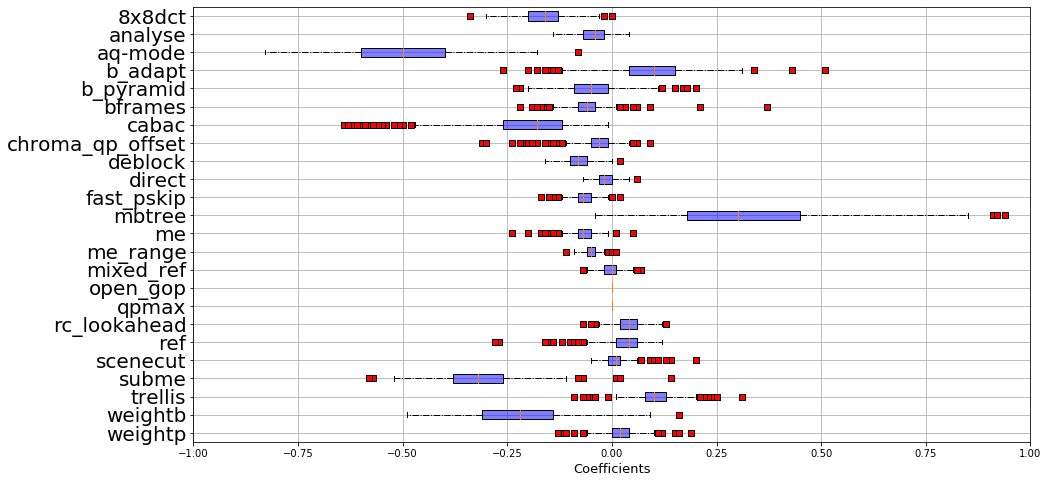



Mean cpu in the group: 1074.5
Std dev : cpu in the group: 398.9
Mean etime in the group: 8.9
Std dev : etime in the group: 10.7
Mean fps in the group: 389.4
Std dev : fps in the group: 302.9
Mean kbs in the group: 15015.6
Std dev : kbs in the group: 19927.0
Mean size in the group: 37383809.7
Std dev : size in the group: 49629655.1


str_video_cat
Animation         0.252874
CoverSong         0.277108
Gaming            0.363636
HDR               0.057692
HowTo             0.252874
Lecture           0.086538
LiveMusic         0.324324
LyricVideo        0.216667
MusicVideo        0.282051
NewsClip          0.489583
Sports            0.567742
TelevisionClip    0.254545
VR                0.426966
VerticalVideo     0.289474
Vlog              0.449367
dtype: float64


Mean perf_group : 0.0
std perf_group : 0.0
Mean SLEEQ_DMOS : -0.029323948203180957
std SLEEQ_DMOS : 0.9164326353194944
Mean BANDING_DMOS : -0.1830523651266118
std BANDING_DMOS : 0.5248708286866567
Mean WIDTH : -0.06749438276653

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    220900.000000
mean          0.817473
std           0.106043
min           0.150032
25%           0.758338
50%           0.837353
75%           0.897179
max           1.000000
dtype: float64



In [11]:
summary_group(0)

Group 1 : 219 videos!


input avg size : 4415585852.876713
input std size : 7212521059.6005535




Imp mbtree: 0.47662100456621004
Imp std mbtree: 0.19637234624965294
Imp aq-mode: 0.13273972602739725
Imp std aq-mode: 0.1266778923958034
Imp subme: 0.14547945205479454
Imp std subme: 0.1496971777007566


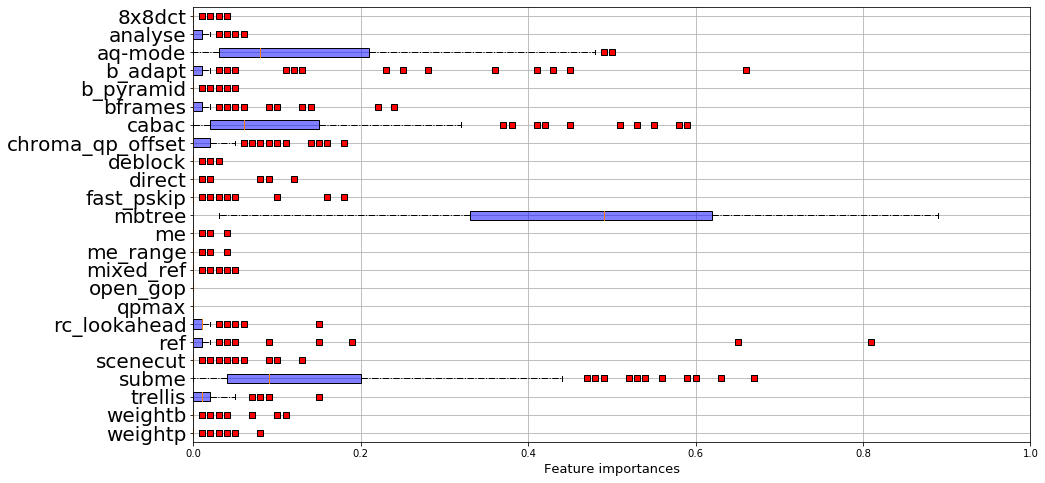



Coef mbtree: -0.6810958904109589
Coef mbtree std : 0.18010824987381613
Coef aq-mode: 0.3553881278538813
Coef aq_mode std : 0.20988844622573236
Coef subme: -0.16114155251141554
Coef subme std: 0.12383916900657123


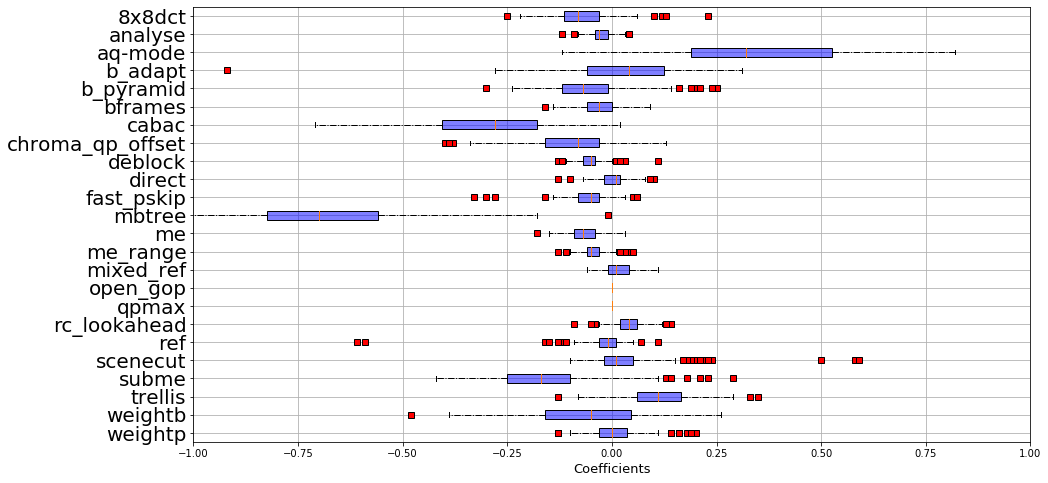



Mean cpu in the group: 1029.7
Std dev : cpu in the group: 377.2
Mean etime in the group: 19.1
Std dev : etime in the group: 30.4
Mean fps in the group: 244.2
Std dev : fps in the group: 256.7
Mean kbs in the group: 9223.9
Std dev : kbs in the group: 11328.4
Mean size in the group: 22805170.5
Std dev : size in the group: 28350618.9


str_video_cat
Animation         0.126437
CoverSong         0.216867
Gaming            0.139860
HDR               0.519231
HowTo             0.103448
Lecture           0.240385
LiveMusic         0.135135
LyricVideo        0.183333
MusicVideo        0.153846
NewsClip          0.062500
Sports            0.064516
TelevisionClip    0.072727
VR                0.089888
VerticalVideo     0.197368
Vlog              0.208861
dtype: float64


Mean perf_group : 1.0
std perf_group : 0.0
Mean SLEEQ_DMOS : 0.005360393998249836
std SLEEQ_DMOS : 0.8958933053763064
Mean BANDING_DMOS : 0.1688188082623658
std BANDING_DMOS : 1.20468743040557
Mean WIDTH : 0.521797505328845
std

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    47961.000000
mean         0.792342
std          0.139192
min         -0.070206
25%          0.727803
50%          0.824210
75%          0.891503
max          1.000000
dtype: float64



In [12]:
summary_group(1)

Group 2 : 292 videos!


input avg size : 2092791930.6780822
input std size : 3964394793.670366




Imp mbtree: 0.34044520547945206
Imp std mbtree: 0.22810447410594462
Imp aq-mode: 0.04373287671232877
Imp std aq-mode: 0.07333146655846272
Imp subme: 0.3654109589041096
Imp std subme: 0.25201143350972877


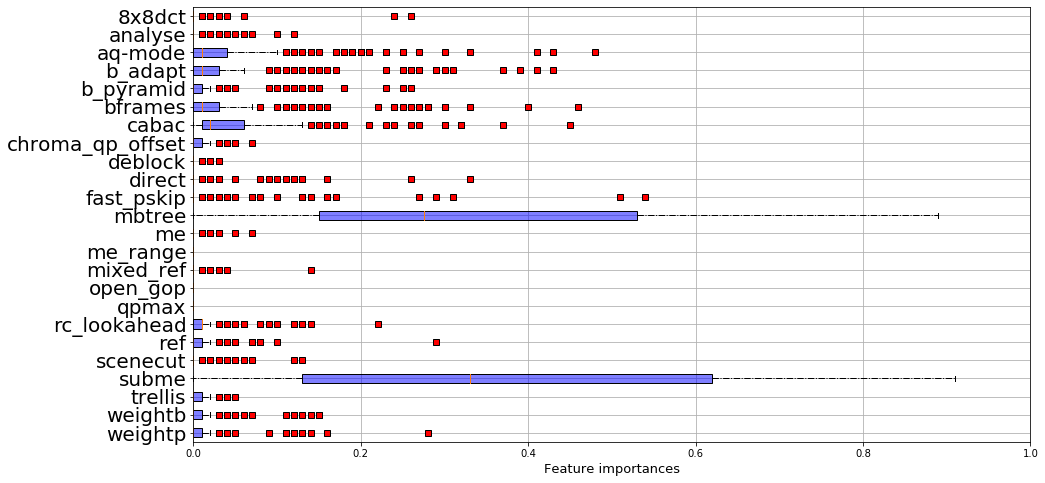



Coef mbtree: -0.41743150684931507
Coef mbtree std : 0.14839983973029075
Coef aq-mode: -0.1354109589041096
Coef aq_mode std : 0.13883135878205718
Coef subme: -0.23380136986301372
Coef subme std: 0.10317694070873534


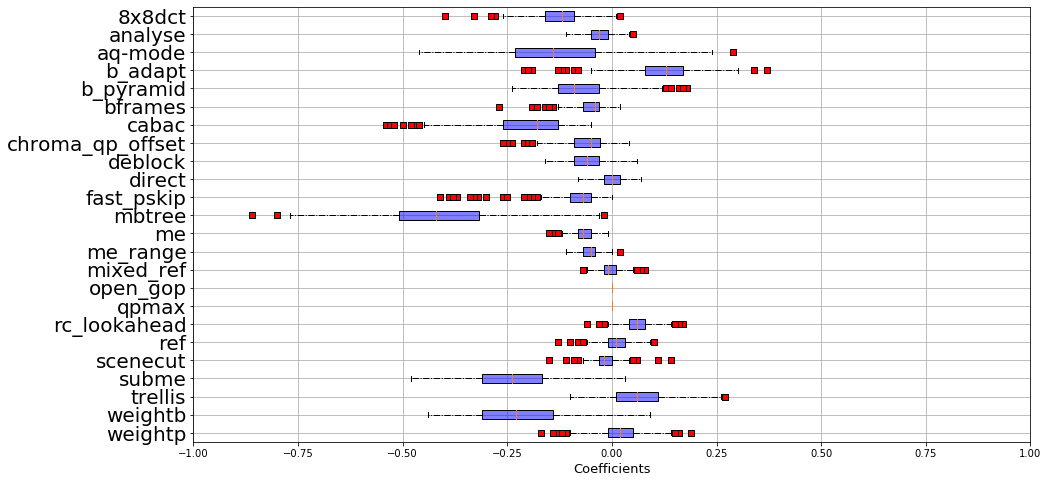



Mean cpu in the group: 813.9
Std dev : cpu in the group: 345.9
Mean etime in the group: 8.4
Std dev : etime in the group: 16.5
Mean fps in the group: 546.0
Std dev : fps in the group: 434.1
Mean kbs in the group: 4882.3
Std dev : kbs in the group: 9150.7
Mean size in the group: 12024467.4
Std dev : size in the group: 22828024.5


str_video_cat
Animation         0.321839
CoverSong         0.325301
Gaming            0.132867
HDR               0.211538
HowTo             0.356322
Lecture           0.375000
LiveMusic         0.148649
LyricVideo        0.300000
MusicVideo        0.192308
NewsClip          0.114583
Sports            0.109677
TelevisionClip    0.381818
VR                0.179775
VerticalVideo     0.171053
Vlog              0.094937
dtype: float64


Mean perf_group : 2.0
std perf_group : 0.0
Mean SLEEQ_DMOS : -0.01814251799112101
std SLEEQ_DMOS : 1.1494241899350455
Mean BANDING_DMOS : 0.25552197476787375
std BANDING_DMOS : 1.4454605442030628
Mean WIDTH : -0.07598371613632829


/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    85264.000000
mean         0.854160
std          0.087861
min          0.388941
25%          0.806319
50%          0.870667
75%          0.920543
max          1.000000
dtype: float64



In [13]:
summary_group(2)

Group 3 : 416 videos!


input avg size : 1930201013.7163463
input std size : 4601483233.336385




Imp mbtree: 0.053942307692307706
Imp std mbtree: 0.06881089288252218
Imp aq-mode: 0.15201923076923077
Imp std aq-mode: 0.18427028542799836
Imp subme: 0.5104807692307692
Imp std subme: 0.25225570744359743


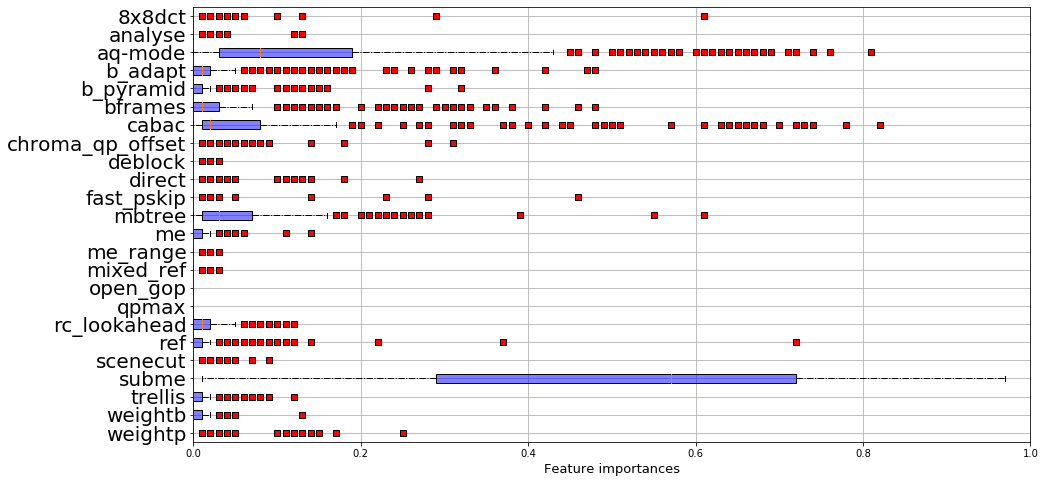



Coef mbtree: -0.1120673076923077
Coef mbtree std : 0.14862528801958744
Coef aq-mode: -0.28807692307692306
Coef aq_mode std : 0.1810244720126415
Coef subme: -0.28870192307692305
Coef subme std: 0.1088345056114392


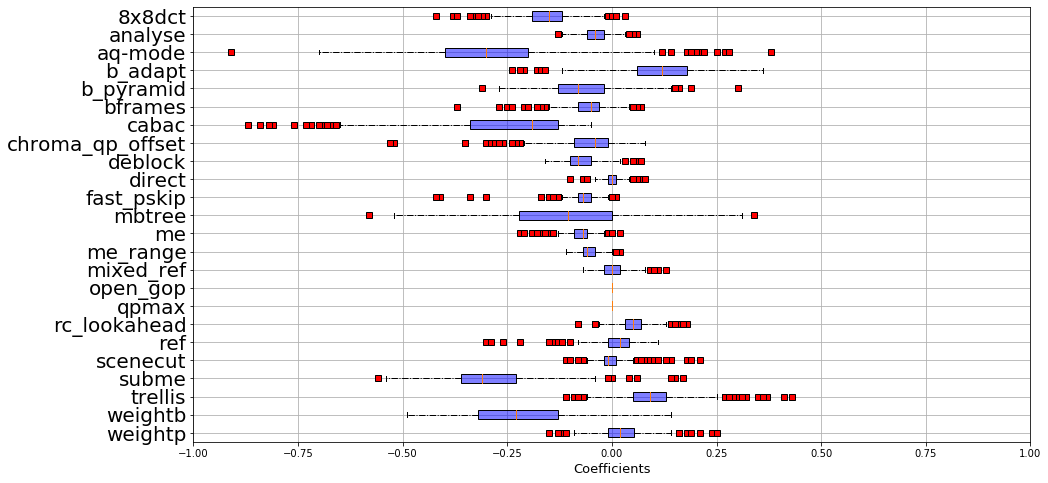



Mean cpu in the group: 912.9
Std dev : cpu in the group: 354.9
Mean etime in the group: 8.9
Std dev : etime in the group: 19.8
Mean fps in the group: 480.0
Std dev : fps in the group: 361.5
Mean kbs in the group: 7462.7
Std dev : kbs in the group: 11611.8
Mean size in the group: 18439974.0
Std dev : size in the group: 28795627.9


str_video_cat
Animation         0.298851
CoverSong         0.180723
Gaming            0.363636
HDR               0.211538
HowTo             0.287356
Lecture           0.298077
LiveMusic         0.391892
LyricVideo        0.300000
MusicVideo        0.371795
NewsClip          0.333333
Sports            0.258065
TelevisionClip    0.290909
VR                0.303371
VerticalVideo     0.342105
Vlog              0.246835
dtype: float64


Mean perf_group : 3.0
std perf_group : 0.0
Mean SLEEQ_DMOS : 0.04304313611366742
std SLEEQ_DMOS : 1.0324835249359274
Mean BANDING_DMOS : -0.06141616353886917
std BANDING_DMOS : 0.851350507488393
Mean WIDTH : -0.1451058861897496
s

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    173056.000000
mean          0.733806
std           0.172576
min          -0.157557
25%           0.633778
50%           0.773363
75%           0.867401
max           1.000000
dtype: float64



In [14]:
summary_group(3)

### Inter-group correlogram

In [15]:
group_perf =groups
id_list_0 = [i for i in range(len(listVideo)) if group_perf[i]==1]
id_list_1 = [i for i in range(len(listVideo)) if group_perf[i]==3]
id_list_2 = [i for i in range(len(listVideo)) if group_perf[i]==0]
id_list_3 = [i for i in range(len(listVideo)) if group_perf[i]==2]

res = np.zeros(16).reshape(4,4)
stds = np.zeros(16).reshape(4,4)
res_med = np.zeros(16).reshape(4,4)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res[0][1] = np.mean(tab)
stds[0][1] = np.std(tab)
res_med[0][1] = np.median(tab)

tab = []
for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res[0][2] = np.mean(tab)
stds[0][2] = np.std(tab)
res_med[0][2] = np.median(tab)

tab = []
for id0 in id_list_0:
    for id3 in id_list_3:
        tab.append(corrSpearman[id0][id3])
res[0][3] = np.mean(tab)
stds[0][3] = np.std(tab)
res_med[0][3] = np.median(tab)

tab = []
for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res[1][2] = np.mean(tab)
stds[1][2] = np.std(tab)
res_med[1][2] = np.median(tab)

tab = []
for id1 in id_list_1:
    for id3 in id_list_3:
        tab.append(corrSpearman[id1][id3])
res[1][3] = np.mean(tab)
stds[1][3] = np.std(tab)
res_med[1][3] = np.median(tab)

tab = []
for id2 in id_list_2:
    for id3 in id_list_3:
        tab.append(corrSpearman[id2][id3])
res[2][3] = np.mean(tab)
stds[2][3] = np.std(tab)
res_med[2][3] = np.median(tab)


res[0][0] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_0] for id2 in id_list_0])
res[1][1] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_1] for id2 in id_list_1])
res[2][2] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_2] for id2 in id_list_2])
res[3][3] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_3] for id2 in id_list_3])

print("AVG")
print(res)
print("STD")
print(stds)
print('MEDIAN')
print(res_med)

AVG
[[0.7923419  0.45023686 0.0414419  0.67379695]
 [0.         0.73380599 0.59842234 0.71700603]
 [0.         0.         0.81747322 0.37538304]
 [0.         0.         0.         0.85416018]]
STD
[[0.         0.20491938 0.21617771 0.17425259]
 [0.         0.         0.17676751 0.15529403]
 [0.         0.         0.         0.18792134]
 [0.         0.         0.         0.        ]]
MEDIAN
[[0.         0.47675224 0.04817805 0.71022817]
 [0.         0.         0.61590102 0.74202928]
 [0.         0.         0.         0.38420647]
 [0.         0.         0.         0.        ]]
